# Import statements

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import random
import os
import sys

# import keras
import keras
from keras import backend as K
backend_keras = keras.backend.backend()
print("keras is using", backend_keras, "as the backend")
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, UpSampling2D
from keras.models import Model, load_model, Sequential

# for training 
# https://keras.io/optimizers/ - list of optimizers, keras documentation
from keras.optimizers import SGD, Nadam, Adamax, Adam, Adadelta, Adagrad, RMSprop


keras is using tensorflow as the backend


# Load proprocessed data - redshift data and labels
These are the ones which have been created with the keras notebook

In [36]:
os.listdir()

['preprocessing.ipynb',
 'CNN1_fixed_esc_frac_0070_redshift_train_with_autoencoder.ipynb',
 'esc0070_labels_test.npy',
 'esc0070_labels_val.npy',
 'esc0070_data_test.npy',
 'esc_frac_0070_labels.npy',
 'CNN1_fixed_esc_frac_0070_redshift_train_no_encoder.ipynb',
 'esc0070_labels_train.npy',
 'esc_frac_0070_data.npy',
 '.ipynb_checkpoints',
 'esc0070_data_train.npy',
 'esc0070_data_val.npy']

In [37]:
x_train_raw = np.load("esc0070_data_train.npy")
x_val_raw = np.load("esc0070_data_val.npy")
x_test_raw = np.load("esc0070_data_test.npy")
labels_train = np.load("esc0070_labels_train.npy")
labels_val = np.load("esc0070_labels_val.npy")
labels_test = np.load("esc0070_labels_test.npy")

print("shapes : ", x_train_raw.shape, x_val_raw.shape, x_test_raw.shape)
print("more shapes", labels_train.shape, labels_val.shape, labels_test.shape)

shapes :  (2550, 200, 200, 1) (340, 200, 200, 1) (510, 200, 200, 1)
more shapes (2550, 17) (340, 17) (510, 17)


# Apply Autoencoder
## first load the autoencoder

In [38]:
os.listdir("../../Auto-Encoder Training/")
autoencoder = load_model("../../Auto-Encoder Training/autoencoder_adam_95.model")

In [39]:
#autoencoder.summary()
encoder = Model(autoencoder.input, autoencoder.layers[-8].output)
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 8)       1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 8)         0   

In [40]:
x_train = encoder.predict(x_train_raw)
x_val = encoder.predict(x_val_raw)
x_test = encoder.predict(x_test_raw)

# Define the CNN architecture

In [47]:
classifier = Sequential()

# extract features
classifier.add(Conv2D(16, (3,3), input_shape=(25,25,8),
                     activation='relu', padding='valid'))
# reduce dimensionality, keep most important info
classifier.add(MaxPooling2D(pool_size=(2,2)))

# add a second layer, again with no padding
classifier.add(Conv2D(8, (3,3), activation='relu', padding='valid'))

# pool again
classifier.add(MaxPooling2D(pool_size=(2,2)))

# here i flatten and then guess the class
classifier.add(Flatten())

# fully connected layers ensures connections to all activations 
# in previous layers

classifier.add(Dense(units=17, activation='softmax'))

# Alternative Architectures

In [48]:
#classifier = Sequential()

# padding = 'valid' means that i reduce dimentionality a little


# Tune hyperparams and compile

In [49]:
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999,
          amsgrad=True)

classifier.compile(optimizer=opt,
                   loss='categorical_crossentropy',
                   metrics=["accuracy"])
print("printing summary of model")
classifier.summary()

printing summary of model
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 23, 23, 16)        1168      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 9, 9, 8)           1160      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 17)                2193      
Total params: 4,521
Trainable params: 4,521
Non-trainable params: 0
_________________________

# Train the network

In [50]:
print(x_train.shape, labels_train.shape)

(2550, 25, 25, 8) (2550, 17)


In [52]:
EPOCHS = 100

H = classifier.fit(x_train, labels_train,
                  epochs = EPOCHS,
                  batch_size = 128,
                  shuffle=True,
                  validation_data=(x_val,labels_val))

Train on 2550 samples, validate on 340 samples
Epoch 1/100
2550/2550 [==============================] - 1s 311us/step - loss: 0.6687 - accuracy: 0.8133 - val_loss: 0.6516 - val_accuracy: 0.8324
Epoch 2/100
2550/2550 [==============================] - 1s 399us/step - loss: 0.6392 - accuracy: 0.8184 - val_loss: 0.6138 - val_accuracy: 0.8559
Epoch 3/100
2550/2550 [==============================] - 1s 554us/step - loss: 0.6049 - accuracy: 0.8192 - val_loss: 0.5905 - val_accuracy: 0.8618
Epoch 4/100
2550/2550 [==============================] - 2s 692us/step - loss: 0.5815 - accuracy: 0.8404 - val_loss: 0.5599 - val_accuracy: 0.8647
Epoch 5/100
2550/2550 [==============================] - 2s 711us/step - loss: 0.5576 - accuracy: 0.8510 - val_loss: 0.5437 - val_accuracy: 0.8794
Epoch 6/100
2550/2550 [==============================] - 1s 482us/step - loss: 0.5329 - accuracy: 0.8588 - val_loss: 0.5437 - val_accuracy: 0.8824
Epoch 7/100
2550/2550 [==============================] - 1s 369us/step 

2550/2550 [==============================] - 1s 331us/step - loss: 0.1626 - accuracy: 0.9569 - val_loss: 0.1554 - val_accuracy: 0.9735
Epoch 57/100
2550/2550 [==============================] - 1s 496us/step - loss: 0.1567 - accuracy: 0.9580 - val_loss: 0.1590 - val_accuracy: 0.9676
Epoch 58/100
2550/2550 [==============================] - 1s 323us/step - loss: 0.1610 - accuracy: 0.9588 - val_loss: 0.1499 - val_accuracy: 0.9765
Epoch 59/100
2550/2550 [==============================] - 1s 451us/step - loss: 0.1616 - accuracy: 0.9518 - val_loss: 0.1602 - val_accuracy: 0.9588
Epoch 60/100
2550/2550 [==============================] - 1s 393us/step - loss: 0.1489 - accuracy: 0.9627 - val_loss: 0.1414 - val_accuracy: 0.9706
Epoch 61/100
2550/2550 [==============================] - 1s 495us/step - loss: 0.1453 - accuracy: 0.9635 - val_loss: 0.1560 - val_accuracy: 0.9588
Epoch 62/100
2550/2550 [==============================] - 1s 385us/step - loss: 0.1422 - accuracy: 0.9635 - val_loss: 0.1583 

# Evaluate the network - Display netowrk stats and save plots

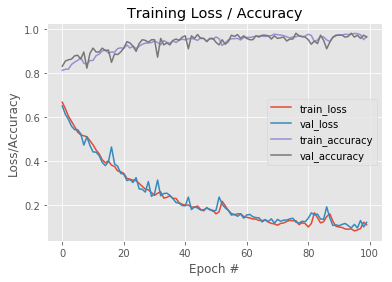

In [60]:
# plot the training loss and accuracy for each epoch
N = np.arange(0,EPOCHS)
plt.figure()
plt.style.use("ggplot")
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_accuracy")
plt.plot(N, H.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss / Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("training_perf_100_arch_01_fix_esc_encoder.png")
plt.show()

# OR load trained CNN

# Save the weights

In [59]:
classifier.save("keras_arch_01_with_encoder_esc_fix.model")

# Make prediction

In [64]:
pred = classifier.predict(x_test)
print(pred.shape,labels_test.shape)
l = len(pred)

(510, 17) (510, 17)


In [66]:
right,wrong = 0,0
for i in range(len(pred)):
    if pred[i].all()==labels_test[i].all(): right+=1
    else: wrong+=1
count = right+wrong

In [71]:
print("right, wrong : ",right,wrong)
print("percentage correct = ",100.0*float(right)/count,"%")

right, wrong :  510 0
percentage correct =  100.0 %
